Number of frames:  1951
Converting video..

Done extracting frames.
1951 frames extracted
It took 28 seconds forconversion.


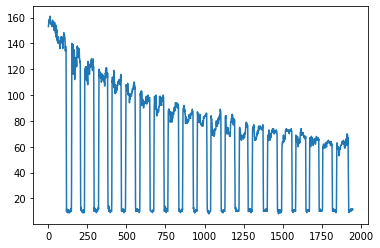

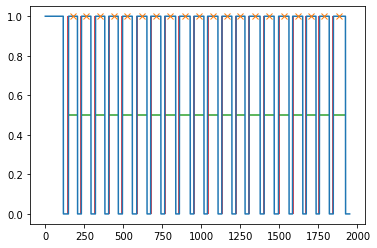

Word length :  58.0
Pick Frame length :  50


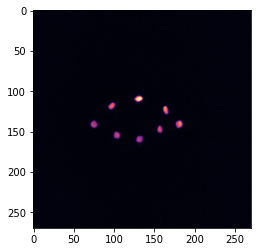

(270, 270, 5) ./data/raw_data\fracture_1.mp4 ./data/fracture/
Number of frames:  2093
Converting video..

Done extracting frames.
2093 frames extracted
It took 30 seconds forconversion.


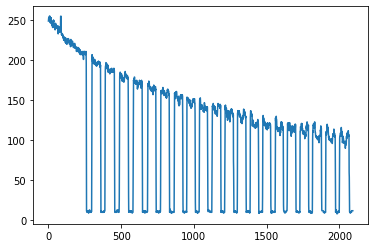

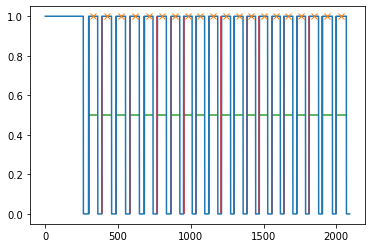

Word length :  57.0
Pick Frame length :  50


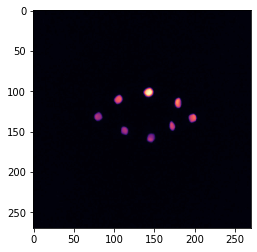

(270, 270, 5) ./data/raw_data\mechanic_1.mp4 ./data/mechanic/
Number of frames:  1896
Converting video..

Done extracting frames.
1896 frames extracted
It took 28 seconds forconversion.


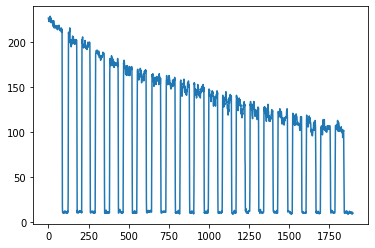

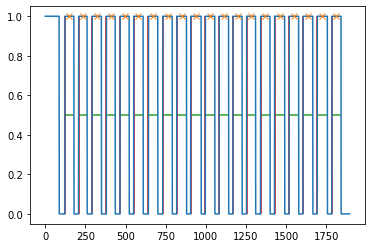

Word length :  53.0


KeyboardInterrupt: 

In [3]:
import cv2
import numpy as np
import matplotlib as plt
import pandas as pd
import time
import tqdm
import os
import matplotlib.pyplot as plt
from scipy.signal import chirp, find_peaks, peak_widths
import glob

def start_pint(x):
    peaks, _ = find_peaks(x, height=-40)
    results_half = peak_widths(x, peaks, rel_height=0.5)
    plt.plot(x)
    plt.plot(peaks, x[peaks], "x")
    plt.hlines(*results_half[1:], color="C2")
    result = peaks-results_half[0]/2
    plt.vlines(result,0,1,color='red')
    plt.show()
    plt.close()
    print("Word length : ",np.min(results_half[0]))
    return result

def video_to_frames(input_loc):
    time_start = time.time()
    cap = cv2.VideoCapture(input_loc)
    video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1
    print ("Number of frames: ", video_length)
    count = 0
    image_max = []
    image_value=np.array([],dtype=int)
    print ("Converting video..\n")
    while cap.isOpened():
        ret, frame = cap.read()
        if np.max(frame)>25 :
            image_value = np.append(image_value, 1)
        else :
            image_value = np.append(image_value, 0)
        image_max.append(np.max(frame))
        count = count + 1
        if (count > (video_length-1)):
            time_end = time.time()
            cap.release()
            print ("Done extracting frames.\n%d frames extracted" % count)
            print ("It took %d seconds forconversion." % (time_end-time_start))
            break
    plt.plot(image_max)
    plt.show()
    plt.close()
    return np.round(start_pint(image_value)).astype('int')

def make_dataset(input_loc, output_loc, start_point, jump=10, number=5):
    try:
        os.mkdir(output_loc)
    except OSError:
        pass
    cap = cv2.VideoCapture(input_loc)
    video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1
    count = 0
    all_point = []
    dataset = []
    for i in start_point:
        for _ in range(number):
            all_point.append(i+jump)
            i+=jump
    while cap.isOpened():
        ret, frame = cap.read()
        if count in all_point:
            dataset.append(breeding(frame))
        else:
            pass
        count = count + 1
        if (count > (video_length-1)):
            cap.release()
            break
    print("Pick Frame length : ", jump*number)
    return dataset, number

def stack_array(data, number):
    all_data = []
    for i in range(int(np.shape(data)[0]/number)):
        j = number * i
        """If data number change stack change"""
        all_data.append(np.stack([data[0+j], data[1+j], data[2+j], data[3+j], data[4+j]], axis = 2))
    return all_data



def breeding(frame, angle = 0, left_right = 0, up_down = 0, flip = 0):
    """Image Breeding"""

    grayFrame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    cp = (grayFrame.shape[1] / 2, grayFrame.shape[0] / 2)
    rot = cv2.getRotationMatrix2D(cp, angle, 1) # 20도 회전, 스케일 0.5배
    grayFrame = cv2.warpAffine(grayFrame, rot, (0, 0))

    if flip == 1:
        grayFrame = cv2.flip(grayFrame, 1)

    grayFrame = cv2.resize(grayFrame[100+up_down:1000+up_down, 350+left_right:1250+left_right],dsize=(0,0),fx=0.3, fy=0.3)
    return grayFrame

_input_loc = r'./data/raw_data/'

for input_loc in glob.glob(_input_loc+'*.mp4'):
    name = os.path.basename(input_loc).split('_')[0]
    output_loc = (r'./data/'+name+'/')
    array = video_to_frames(input_loc)
    dataset = make_dataset(input_loc, output_loc, array)
    result = stack_array(dataset[0], dataset[1])
    plt.imshow(dataset[0][0],cmap='magma')
    plt.show()
    plt.close()
    print(np.shape(result[0]), input_loc, output_loc)
    np.save(output_loc+name+'_5',result)
